# **Import libraries**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import keras
import os
import cv2
from PIL import Image
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential

# **Load dataset**

In [12]:
DATA_DIR = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/'
SIZE = 64
dataset = []
label = []

> # Parasitized cell images

In [13]:
# set label as 0

parasitized_images = os.listdir(DATA_DIR + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(DATA_DIR + 'Parasitized/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            dataset.append(np.array(image))
            label.append(0)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

> # Uninfected cell images

In [14]:
# set label as 1

uninfected_images = os.listdir(DATA_DIR + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(DATA_DIR + 'Uninfected/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            dataset.append(np.array(image))
            label.append(1)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

# **Visualize data**

> # Parasitized images

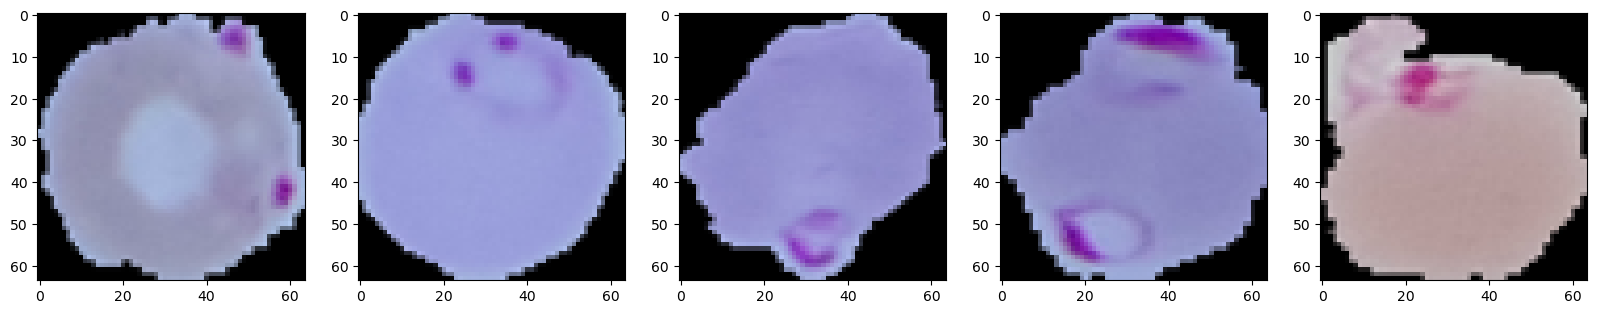

In [15]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(parasitized_images), size = 5)):
    plt.subplot(1, 5, index+1)
    plt.imshow(dataset[image_index])

> # Uninfected images

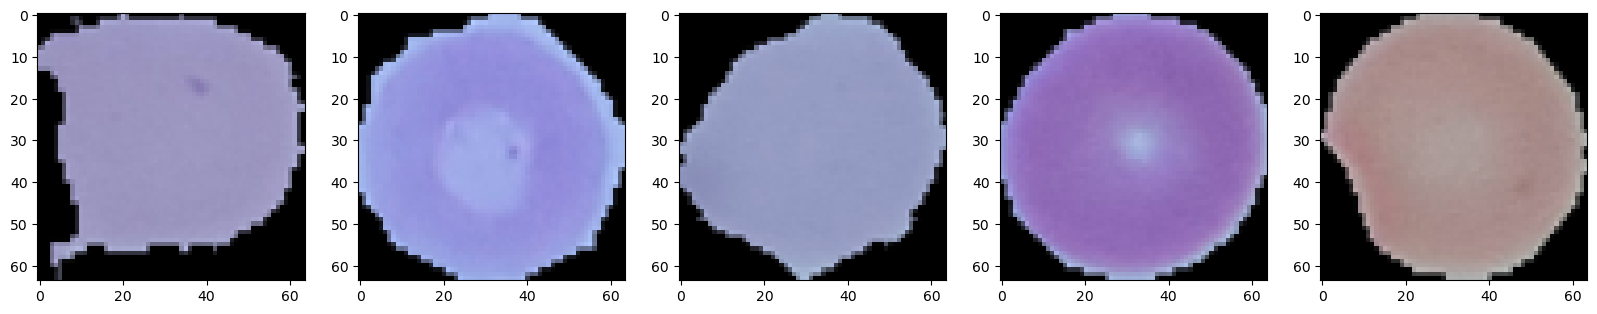

In [16]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(uninfected_images), size = 5)):
    plt.subplot(1, 5, index+1)
    plt.imshow(dataset[len(parasitized_images) + image_index])

# **Build CNN Model**

In [24]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape = (SIZE, SIZE, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(activation = 'relu', units=256))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(activation = 'sigmoid', units=2))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 31, 31, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 30752)             0         
                                                                 
 dense_2 (Dense)             (None, 256)              

# **Split the dataset**

In [18]:
from keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state = 0)

# **Training**

In [25]:
from keras.callbacks import EarlyStopping
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]

In [26]:
history = model.fit(np.array(X_train), y_train, batch_size = 64, epochs = 50, validation_split = 0.1, callbacks=callbacks)

Epoch 1/50


2023-03-30 19:35:56.885478: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


311/311 [==============================] - 5s 8ms/step - loss: 0.6422 - accuracy: 0.6745 - val_loss: 1.6676 - val_accuracy: 0.4934
Epoch 2/50
311/311 [==============================] - 2s 8ms/step - loss: 0.4378 - accuracy: 0.7998 - val_loss: 1.0917 - val_accuracy: 0.6925
Epoch 3/50
311/311 [==============================] - 2s 8ms/step - loss: 0.2678 - accuracy: 0.8975 - val_loss: 0.4294 - val_accuracy: 0.8866
Epoch 4/50
311/311 [==============================] - 2s 8ms/step - loss: 0.2136 - accuracy: 0.9203 - val_loss: 0.2510 - val_accuracy: 0.9202
Epoch 5/50
311/311 [==============================] - 2s 7ms/step - loss: 0.1869 - accuracy: 0.9289 - val_loss: 0.3139 - val_accuracy: 0.8825
Epoch 6/50
311/311 [==============================] - 2s 8ms/step - loss: 0.1697 - accuracy: 0.9381 - val_loss: 0.2365 - val_accuracy: 0.9111
Epoch 7/50
311/311 [==============================] - 2s 7ms/step - loss: 0.1487 - accuracy: 0.9453 - val_loss: 0.7823 - val_accuracy: 0.8186
Epoch 8/50
311/31

# **Evaluation**

In [27]:
print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))

173/173 [==============================] - 1s 3ms/step - loss: 0.2704 - accuracy: 0.9049
Test_Accuracy: 90.49%


# **Improving the accuracy with Augmentation**

In [28]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale = 1/255,
                                     zoom_range = 0.3,
                                     horizontal_flip = True,
                                     rotation_range = 30)

test_generator = ImageDataGenerator(rescale = 1/255)

train_generator = train_generator.flow(np.array(X_train),
                                       y_train,
                                       batch_size = 64,
                                       shuffle = False)

test_generator = test_generator.flow(np.array(X_test),
                                     y_test,
                                     batch_size = 64,
                                     shuffle = False)

In [29]:
history = model.fit_generator(train_generator,
                                   steps_per_epoch = len(X_train)/64,
                                   epochs = 50,
                                   callbacks=callbacks)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.
2023-03-30 19:36:21.625489: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


344/344 [==============================] - 29s 83ms/step - loss: 0.4225 - accuracy: 0.8300
Epoch 2/50
344/344 [==============================] - 28s 81ms/step - loss: 0.3255 - accuracy: 0.8761
Epoch 3/50
344/344 [==============================] - 29s 83ms/step - loss: 0.3039 - accuracy: 0.8874
Epoch 4/50
344/344 [==============================] - 28s 81ms/step - loss: 0.2881 - accuracy: 0.8928
Epoch 5/50
344/344 [==============================] - 28s 81ms/step - loss: 0.2827 - accuracy: 0.8968
Epoch 6/50
344/344 [==============================] - 28s 81ms/step - loss: 0.2793 - accuracy: 0.8968
Epoch 7/50
344/344 [==============================] - 28s 81ms/step - loss: 0.2690 - accuracy: 0.9041
Epoch 8/50
344/344 [==============================] - 28s 81ms/step - loss: 0.2670 - accuracy: 0.9025
Epoch 9/50
344/344 [==============================] - 28s 80ms/step - loss: 0.2600 - accuracy: 0.9056
Epoch 10/50
344/344 [==============================] - 31s 89ms/step - loss: 0.2639 - accurac

# **Evaluation**

In [30]:
print("Test_Accuracy(after augmentation): {:.2f}%".format(model.evaluate_generator(test_generator, steps = len(X_test), verbose = 1)[1]*100))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


5512/5512 [==============================] - 1s 123us/step - loss: 0.1780 - accuracy: 0.9370
Test_Accuracy(after augmentation): 93.70%
